## Homework 6

In this homework, you will use PyTorch for the NSL-KDD dataset to build neural networks and
write training loops to predict not just whether there is an attack, but also the type of the
attack. In other words, this is a multi-class classification problem with 5 possible categories
(normal, DOS, R2L, U2R, probing)

### Q1
Prepare the data and convert them to 3 Datasets in PyTorch for training, validation,
and testing respectively. You may use KDDTrain+.txt as the training dataset, 50% of
KDDTest+.txt as the validation dataset, and the remaining 50% as the test dataset. If during the
data preparation, an error occurs due to the size of the dataset, you may use a subset of these
datasets.

**Prepare dataset**

In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","classes","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        def attack_category(attack_type):
            if attack_type == 'normal':
                return 0
            elif attack_type in ['port-Sweep', 'ip-Sweep', 'nmap', 'satan', 'saint', 'mscan']:
                return 1  # Probing
            elif attack_type in ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2',
                                'udpstorm', 'processtable', 'mail-Bomb']:
                return 2  # Dos
            elif attack_type in ['buffer-Overflow', 'load-Module', 'perl', 'rootkit', 'xterm',
                                'ps', 'sqlattack']:
                return 3  # U2R
            else:
                return 4  # R2L
          
        # Convert the function to a UDF, specifying IntegerType for output
        label_to_multiclasses = udf(attack_category, IntegerType())
        output_df = dataset.withColumn('outcome', label_to_multiclasses(col('classes'))).drop("classes")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty_level')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    
    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [ ]:
import torch
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt

# Contribute Spark
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Pytorch") \
    .getOrCreate()

# Load train and test data
nslkdd_raw = spark.read.csv('./NSL-KDD/KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('./NSL-KDD/KDDTest+.txt',header=False).toDF(*col_names)
print("train dataset: ", nslkdd_raw.count())
print("test dataset: ", nslkdd_test_raw.count())

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)


nslkdd_df.cache()
nslkdd_df_test.cache()

# Split test data into validation dataset and test dataset
val_df, test_df = nslkdd_df_test.randomSplit(weights=[0.5,0.5], seed=100)

# Convert Spark to Pandas
nslkdd_df_pandas = nslkdd_df.toPandas()
val_df_pandas = val_df.toPandas()
test_df_pandas = test_df.toPandas()

# Convert Pandas df to Numpy array to torch 
x_train = torch.from_numpy(np.array(nslkdd_df_pandas['features'].values.tolist(),np.float32))
y_train = torch.from_numpy(np.array(nslkdd_df_pandas['outcome'].values.tolist(),np.float64))

x_validate = torch.from_numpy(np.array(val_df_pandas['features'].values.tolist(),np.float32))
y_validate = torch.from_numpy(np.array(val_df_pandas['outcome'].values.tolist(),np.float64))

x_test = torch.from_numpy(np.array(test_df_pandas['features'].values.tolist(),np.float32))
y_test = torch.from_numpy(np.array(test_df_pandas['outcome'].values.tolist(),np.float64))

24/11/02 22:18:32 WARN Utils: Your hostname, Kitiyas-MacBook-Air-5.local resolves to a loopback address: 127.0.0.1; using 10.0.0.202 instead (on interface en0)
24/11/02 22:18:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/02 22:18:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


train dataset:  125973
test dataset:  22544


24/11/02 22:18:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
from torch.utils.data import Dataset,DataLoader
# Convert the tensors to datasets
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
train_dataset = MyDataset(x_train, y_train)
validate_dataset = MyDataset(x_validate, y_validate)
test_dataset = MyDataset(x_test, y_test)

In [4]:
# Train set sizes
print("x train set size: ",x_train.shape) # N_input = 113
print("y train set size: ",y_train.shape) # N_output = 1
print("---") 

# Validation set sizes
print("x validation set size: ",x_validate.shape) 
print("y validation set size: ",y_validate.shape)
print("---") 

# Test set sizes
print("x test set size: ",x_test.shape) 
print("y test set size: ",y_test.shape)

x train set size:  torch.Size([125973, 113])
y train set size:  torch.Size([125973])
---
x validation set size:  torch.Size([11312, 113])
y validation set size:  torch.Size([11312])
---
x test set size:  torch.Size([11232, 113])
y test set size:  torch.Size([11232])


### Q2

Build a Neural Network via subclassing nn.Module. You may choose your own
activation function, number of layers, and number of neurons in each layer. Include a screenshot of the printout of your model (that is, print(mymodel) where mymodel is your model instance)

**Create a NN model**

In [5]:
class MultiLayerPercepton(nn.Module):
    def __init__(self, N_in, N_out):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(N_in, 5),
            nn.ReLU(),
            nn.Linear(5, N_out)
        )
    def forward(self,x):
        return self.model(x)

In [6]:
# Initial model
N_in = x_train.shape[1]
N_out = 5
model = MultiLayerPercepton(N_in,N_out)
print("model structure: \n")
print(model)

model structure: 

MultiLayerPercepton(
  (model): Sequential(
    (0): Linear(in_features=113, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
  )
)


Refer to q2.png

### Q3

Write a training loop that contains at least the following features: 
- conduct validation for each epoch
- compute the train/validate loss/metric for each epoch
- print out the progress of each epoch
- save the current best model so far at every epoch.

You may choose your own metric.

Further, after the training loop, plot three figures:

• The train loss per SGD iteration, that is, the train loss of every batch across all batches in all epochs. The horizontal axis should range from 1 to the total number of train iterations, which equals (number of epochs)*(number of batches in training data).

• The train and validate loss across different epochs.

• The train and validate metric across different epochs.

Please select your own hyper-parameters and conduct a run of the training loop, and in your submission, include a screenshot of the printout of the training loop and the three figures.

**Triaining loop**

In [ ]:
from torch.utils.data import Dataset, DataLoader
def train_loop(mymodel, batch_size, epochs, lossfn, optimizer,modelname):
    # Create dataloaders for training and validation
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    validate_dataloader = DataLoader(validate_dataset,batch_size = batch_size,shuffle = True)

    losses_all = []

    train_losses = []
    train_acc = []

    validation_losses = []
    validation_acc = []

    current_best_acc = 0

    gd_steps = 0 # number of total gradient steps

    for epoch in range(epochs):
        batch_loss = [] # keep a list of losses for diff bathes in each epoch
        batch_acc = [] # keep a list of accuracy for diff batches in each epoch 
        # Calculate Train Loss
        for batch_id, (x_batch, y_batch) in enumerate(train_dataloader):
            gd_steps+=1
            # Pass input data to get the prediction outputs by the current model
            prediction = mymodel(x_batch)

            # Compare prediction and the actual output and compute the loss
            loss = lossfn(prediction, y_batch.long())

            # Compute the gradient
            optimizer.zero_grad()
            loss.backward()

            # Update parameters
            optimizer.step()

            # Record loss of this batch
            losses_all.append(loss.item())
            batch_loss.append(loss.item())

            # Compute accuracy matric for this batch
            predict_label = torch.argmax(prediction.detach(), dim=1).numpy()
            batch_acc.append(np.sum(predict_label == y_batch.numpy()) / x_batch.shape[0])

        # Calculate Validation Loss
        validate_batch_loss = []
        validate_batch_acc = []
        for x_batch, y_batch in validate_dataloader:
            with torch.no_grad():
                # Pass input data to get the prediction outputs by the current model
                prediction = mymodel(x_batch)

                # Compare prediction and the actual output and compute the loss
                loss = lossfn(prediction, y_batch.long())
                validate_batch_loss.append(loss.item())

                # Compute accuracy matric for this batch
                predict_label = torch.argmax(prediction.detach(), dim=1).numpy()
                validate_batch_acc.append(np.sum(predict_label == y_batch.numpy()) / x_batch.shape[0])

        # Calculate the avg train loss and validation loss in each epoch and record
        train_losses.append(np.mean(np.array(batch_loss)))
        validation_losses.append( np.mean(np.array(validate_batch_loss)))
        
        # Compute accuracy metric for each epoch
        train_acc.append(np.mean(np.array(batch_acc)))
        validation_acc.append(np.mean(np.array(validate_batch_acc)))
        

        # Print out the progress of each epoch
        print(f"Epoch {epoch:>4} of {epochs}: Train Loss = {train_losses[epoch]:.4f}, Validation Loss = {validation_losses[epoch]:.4f}")
        print(f"Train accuray = {train_acc[epoch]*100:.2f}%, Validation accuracy = {validation_acc[epoch]*100:.2f}%")

        # Save the current best model
        if validation_acc[-1] > current_best_acc:
            current_best_acc = validation_acc[-1]
            torch.save(mymodel.state_dict(), modelname)
            print("Current epoch is the best so far. Saving model...")

        print("----------")
    return losses_all, train_acc, train_losses, validation_acc, validation_losses, gd_steps

In [8]:
# Config model
mymodel = model

# Prepare parameters for training loop
lr = 1e-3
batch_size = 20
epochs = 10
lossfn = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.SGD(mymodel.parameters(), lr = lr)

# Train loop
losses_all, train_acc, train_losses, validation_acc, validation_losses, gd_steps = train_loop(mymodel,batch_size,epochs,lossfn,optimizer,'best_model_q3')

Epoch    0 of 10: Train Loss = 0.4389, Validation Loss = 1.1688
Train accuray = 87.20%, Validation accuracy = 65.99%
Current epoch is the best so far. Saving model...
----------
Epoch    1 of 10: Train Loss = 0.2178, Validation Loss = 1.2183
Train accuray = 93.16%, Validation accuracy = 66.27%
Current epoch is the best so far. Saving model...
----------
Epoch    2 of 10: Train Loss = 0.1833, Validation Loss = 1.2822
Train accuray = 93.52%, Validation accuracy = 66.93%
Current epoch is the best so far. Saving model...
----------
Epoch    3 of 10: Train Loss = 0.1631, Validation Loss = 1.3254
Train accuray = 94.59%, Validation accuracy = 68.02%
Current epoch is the best so far. Saving model...
----------
Epoch    4 of 10: Train Loss = 0.1461, Validation Loss = 1.3743
Train accuray = 95.53%, Validation accuracy = 70.77%
Current epoch is the best so far. Saving model...
----------
Epoch    5 of 10: Train Loss = 0.1315, Validation Loss = 1.3985
Train accuray = 96.00%, Validation accuracy = 

**Show figures**

In [9]:
def plot_figures(subtitle,epochs,train_losses,validation_losses,train_acc,validation_acc,gd_steps, losses_all):
    fig, axs = plt.subplots(2, 2, figsize=(20, 5))

    # The train loss per SGD iteration
    plt.subplot(1, 3, 1)
    plt.plot(range(gd_steps), losses_all)
    plt.xlabel('# of Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss per iteration')
    plt.subplot(1, 3, 2)
    
    # The train and validate loss across different epochs.
    plt.plot(range(epochs), train_losses, label="train loss")
    plt.plot(range(epochs), validation_losses, label="validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss & Validation Loss')
    plt.legend()

    # The train and validate accuracy metric across different epochs.
    plt.subplot(1, 3, 3)
    plt.plot(range(epochs), train_acc, label="train accuracy")
    plt.plot(range(epochs), validation_acc, label="validation accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy & Validation Accuracy')
    plt.legend()

    plt.suptitle(subtitle)
    plt.show()


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_39539/2879705368.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)
/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_39539/2879705368.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)


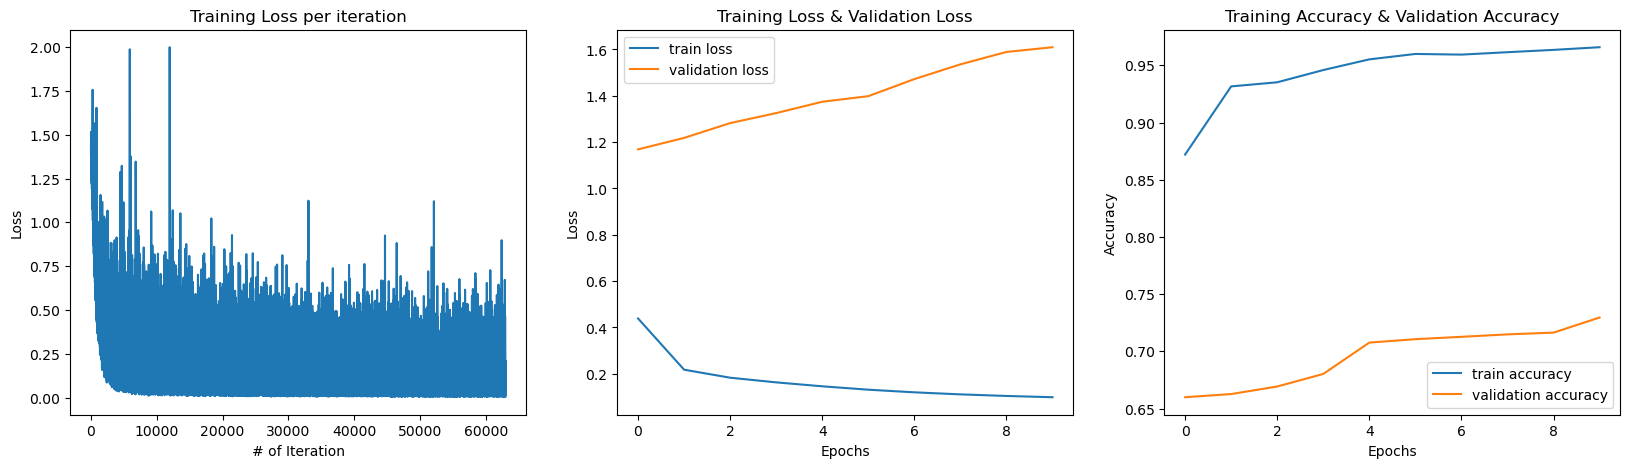

In [10]:
plot_figures("",epochs,train_losses,validation_losses,train_acc,validation_acc,gd_steps, losses_all)

Refer to q3_1.png, q3_2.png, q3_3.png

### Q4

Please tune the training hyper-parameters (learning rate/batch size/number of epochs/choice of optimizer/others) such that your model converges well. Please try at least 3 sets of hyper-parameters, and document the results (the values of the hyper-parameters, screenshots of the printout of the training loop, and the three figures as in Q3). Please provide a short description on your tuning process, including the rationale for choosing the hyper-parameters.

**Set I: Try Adam optimizer**

Epoch    0 of 10: Train Loss = 0.3184, Validation Loss = 228.9149
Train accuray = 87.08%, Validation accuracy = 62.41%
Current epoch is the best so far. Saving model...
----------
Epoch    1 of 10: Train Loss = 0.3169, Validation Loss = 235.9748
Train accuray = 87.15%, Validation accuracy = 62.44%
Current epoch is the best so far. Saving model...
----------
Epoch    2 of 10: Train Loss = 0.3141, Validation Loss = 249.1087
Train accuray = 87.22%, Validation accuracy = 62.61%
Current epoch is the best so far. Saving model...
----------
Epoch    3 of 10: Train Loss = 0.3152, Validation Loss = 256.0723
Train accuray = 87.33%, Validation accuracy = 62.57%
----------
Epoch    4 of 10: Train Loss = 0.3159, Validation Loss = 262.9673
Train accuray = 87.41%, Validation accuracy = 62.61%
Current epoch is the best so far. Saving model...
----------
Epoch    5 of 10: Train Loss = 0.3146, Validation Loss = 266.3198
Train accuray = 87.42%, Validation accuracy = 62.67%
Current epoch is the best so fa

/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_39539/2879705368.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)
/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_39539/2879705368.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)


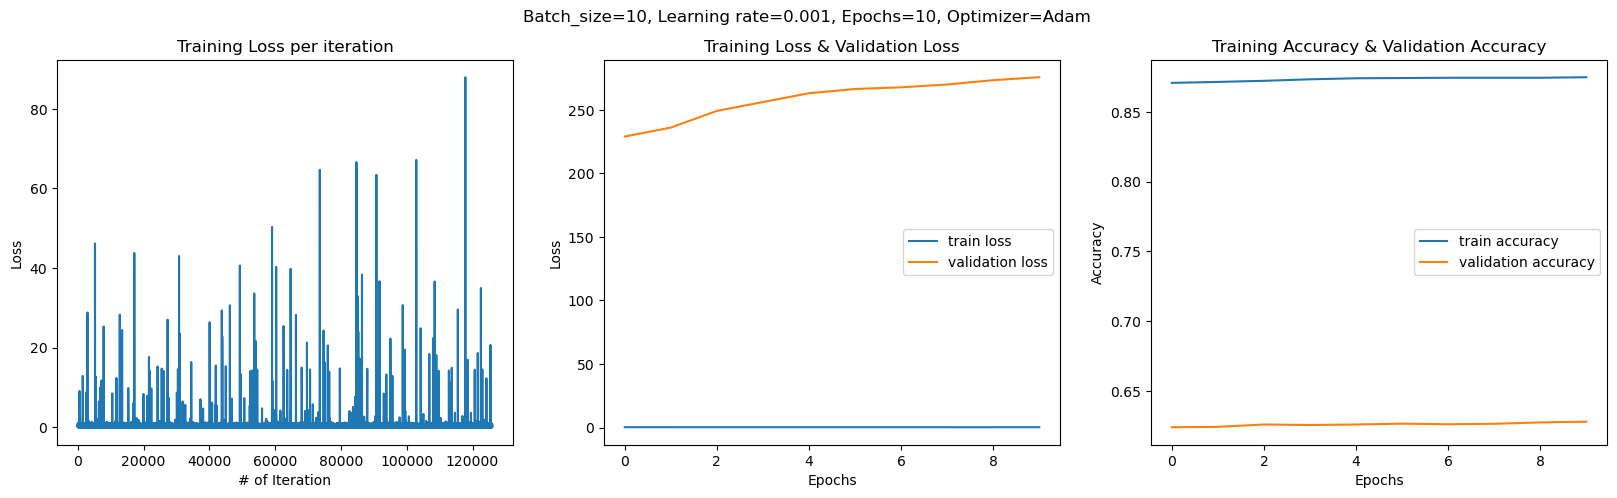

In [20]:
# Config model
mymodel = model

# Prepare parameters for training loop
lr = 1e-3
batch_size = 10
epochs = 10
lossfn = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr)

# Train loop
losses_all, train_acc, train_losses, validation_acc, validation_losses, gd_steps = train_loop(mymodel,batch_size,epochs,lossfn,optimizer,'best_model_q4_1')

# Print loss of train iteration, train/validation loss, train/validation accuracy
plot_figures(f"Batch_size={batch_size}, Learning rate={lr}, Epochs={epochs}, Optimizer=Adam",epochs,train_losses,validation_losses,train_acc,validation_acc,gd_steps, losses_all)

**Set II: Try increase Batch size & decrease learning rate**

Because set I model has large oscillation at the training loss per iteration graph and also overfitting. Increase of batch size and decrease of learning rate may help to reduce this training oscillation.

Epoch    0 of 10: Train Loss = 0.2923, Validation Loss = 14.2000
Train accuray = 88.40%, Validation accuracy = 64.69%
Current epoch is the best so far. Saving model...
----------
Epoch    1 of 10: Train Loss = 0.2837, Validation Loss = 19.5289
Train accuray = 88.60%, Validation accuracy = 64.58%
----------
Epoch    2 of 10: Train Loss = 0.2715, Validation Loss = 24.7018
Train accuray = 88.66%, Validation accuracy = 64.76%
Current epoch is the best so far. Saving model...
----------
Epoch    3 of 10: Train Loss = 0.2645, Validation Loss = 27.2052
Train accuray = 88.74%, Validation accuracy = 64.81%
Current epoch is the best so far. Saving model...
----------
Epoch    4 of 10: Train Loss = 0.2652, Validation Loss = 27.0126
Train accuray = 88.78%, Validation accuracy = 64.77%
----------
Epoch    5 of 10: Train Loss = 0.2634, Validation Loss = 29.7527
Train accuray = 88.79%, Validation accuracy = 65.05%
Current epoch is the best so far. Saving model...
----------
Epoch    6 of 10: Train Lo

/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_39539/2879705368.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)
/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_39539/2879705368.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)


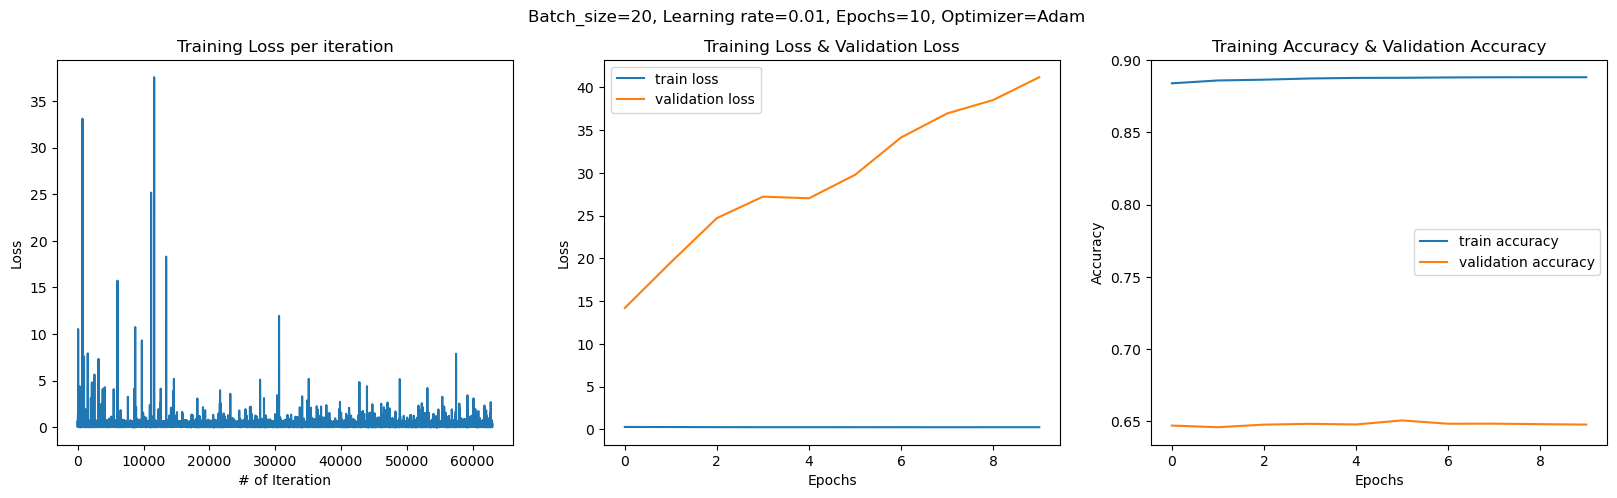

In [12]:
# Prepare parameters for training loop
lr = 1e-2
batch_size = 20
epochs = 10
lossfn = nn.CrossEntropyLoss()

# Create optimizer
optimizer2 = torch.optim.Adam(mymodel.parameters(), lr = lr)

# Train loop
losses_all, train_acc, train_losses, validation_acc, validation_losses, gd_steps = train_loop(mymodel,batch_size,epochs,lossfn,optimizer2,'best_model_q4_2')

# Print loss of train iteration, train/validation loss, train/validation accuracy
plot_figures(f"Batch_size={batch_size}, Learning rate={lr}, Epochs={epochs}, Optimizer=Adam",epochs,train_losses,validation_losses,train_acc,validation_acc,gd_steps, losses_all)

**Set III: Try increase learning rate**

Because set II model still has large oscillation at the training loss per iteration graph and also overfitting. By increase of batch size does not help for overfitting, decreasing more learning rate may help to reduce this training oscillation.

Epoch    0 of 10: Train Loss = 0.2588, Validation Loss = 42.1286
Train accuray = 88.87%, Validation accuracy = 64.81%
Current epoch is the best so far. Saving model...
----------
Epoch    1 of 10: Train Loss = 0.2586, Validation Loss = 41.8176
Train accuray = 88.86%, Validation accuracy = 64.80%
----------
Epoch    2 of 10: Train Loss = 0.2573, Validation Loss = 41.9638
Train accuray = 88.86%, Validation accuracy = 64.76%
----------
Epoch    3 of 10: Train Loss = 0.2568, Validation Loss = 43.2846
Train accuray = 88.86%, Validation accuracy = 64.83%
Current epoch is the best so far. Saving model...
----------
Epoch    4 of 10: Train Loss = 0.2563, Validation Loss = 43.5954
Train accuray = 88.86%, Validation accuracy = 64.78%
----------
Epoch    5 of 10: Train Loss = 0.2561, Validation Loss = 44.6741
Train accuray = 88.86%, Validation accuracy = 64.82%
----------
Epoch    6 of 10: Train Loss = 0.2555, Validation Loss = 45.2257
Train accuray = 88.86%, Validation accuracy = 64.79%
--------

/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_39539/2879705368.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)
/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_39539/2879705368.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)


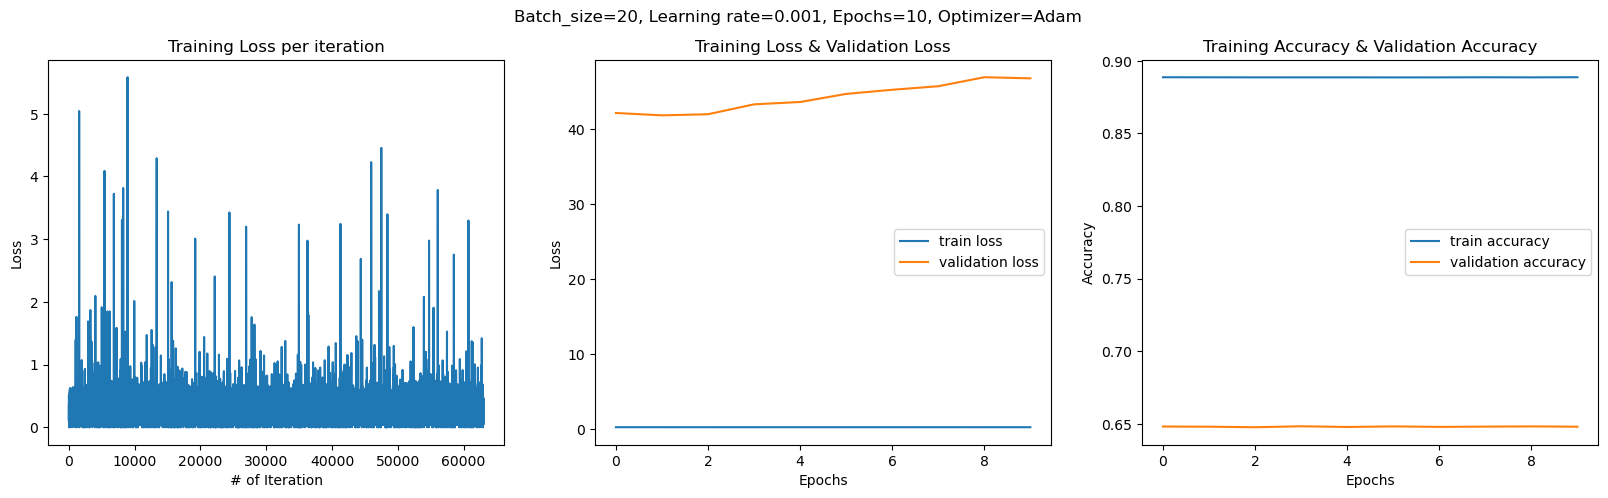

In [13]:
# Prepare parameters for training loop
lr = 1e-3
batch_size = 20
epochs = 10
lossfn = nn.CrossEntropyLoss()

# Create optimizer
optimizer3 = torch.optim.Adam(mymodel.parameters(), lr = lr)

# Train loop
losses_all, train_acc, train_losses, validation_acc, validation_losses, gd_steps = train_loop(mymodel,batch_size,epochs,lossfn,optimizer3,'best_model_q4_3')

# Print loss of train iteration, train/validation loss, train/validation accuracy
plot_figures(f"Batch_size={batch_size}, Learning rate={lr}, Epochs={epochs}, Optimizer=Adam",epochs,train_losses,validation_losses,train_acc,validation_acc,gd_steps, losses_all)

Refer to q4_1.png, q4_2.png, q4_3.png, q4_4.png, q4_5.png, q4_6.png

### Q5

Load back the best model encountered in your best run in Q4, and calculate the metric on the test data set (please include a screenshot). Note that when evaluating the metric, the gradient is not needed, and thus, building the computation graph is not necessary. What should you do to prevent PyTorch from building the computation graph in the evaluation process? Please explain your answer and include a screenshot of the relevant code.

**Answer**

We can use `detach()` or `torch.no_grad()` to prevent PyTorch from building the computation graph in the evaluation process which means that tensor is not going to store previous gradient because we do not have to do back-propagation in evaluation process.

#### Testing

In [ ]:
# Creata a new model with the same input-output dimension as before
mybestmodel = MultiLayerPercepton(N_in,N_out)

# Load the "state_dict" from file into the new model
mybestmodel.load_state_dict(torch.load("best_model_q4_2")) 

/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_39539/3002462669.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mybestmodel.load_state_dict(torch.load("best_

<All keys matched successfully>

In [15]:
# Load test dataset
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

test_batch_acc = []
for x_batch, y_batch in test_dataloader:
        with torch.no_grad():
                # Pass input data to get the prediction outputs by the current model
                prediction = mybestmodel(x_batch)

        # Compute accuracy matric for this batch
        predict_label = torch.argmax(prediction.detach(), dim=1).numpy()
        test_batch_acc.append(np.sum(predict_label == y_batch.numpy()) / x_batch.shape[0])

test_acc = np.mean(np.array(test_batch_acc))
print(f"Test accuracy = {train_acc[-1]*100:.2f}%")

Test accuracy = 88.87%


Refer to q5.png

*References:*

- Guannan Qu. (2024). Lecture 13: Pytorch hyperparameter tuning best practices sildes.
- homework5.ipynb
- https://scales.arabpsychology.com/stats/how-can-i-split-data-into-training-and-test-sets-in-pyspark/#:~:text=In%20PySpark%2C%20this%20can%20be,training%20and%2020%25%20for%20testing.